<a href="https://colab.research.google.com/github/misterlimcodes/tensorflow-binary-and-multiclass-classification-models/blob/main/binary_and_multiclass_neural_network_classification_in_tensorflow_JL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with TensorFlow

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs) 
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

## Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

# BINARY CLASSIFICATION MODEL

In [1]:
# IMPORT LIBS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np


In [2]:
# create data to view and fit

from sklearn.datasets import make_circles
# make_circles is 'a simple toy dataset to visualize clustering and classification algorithms.'

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [3]:
# check features 
X[0:10, :], X.shape
# a matrix, 2 cols, (1000, 2)
# scalar, vector and tensors https://medium.com/linear-algebra/part-4b-tensors-scalars-and-vectors-68cf6c1f2be

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]), (1000, 2))

In [4]:
# check labels
y[0:10], y.shape 
# a vector, 0 cols, (1000,) 

(array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]), (1000,))

In [5]:
# visualise the data, so we can understand it better

import pandas as pd

circles = pd.DataFrame({ 'X0':X[:,0], 'X1':X[:,1], 'Label':y })

circles, circles.shape


(           X0        X1  Label
 0    0.754246  0.231481      1
 1   -0.756159  0.153259      1
 2   -0.815392  0.173282      1
 3   -0.393731  0.692883      1
 4    0.442208 -0.896723      0
 ..        ...       ...    ...
 995  0.244054  0.944125      0
 996 -0.978655 -0.272373      0
 997 -0.136900 -0.810012      1
 998  0.670362 -0.767502      0
 999  0.281057  0.963824      0
 
 [1000 rows x 3 columns], (1000, 3))

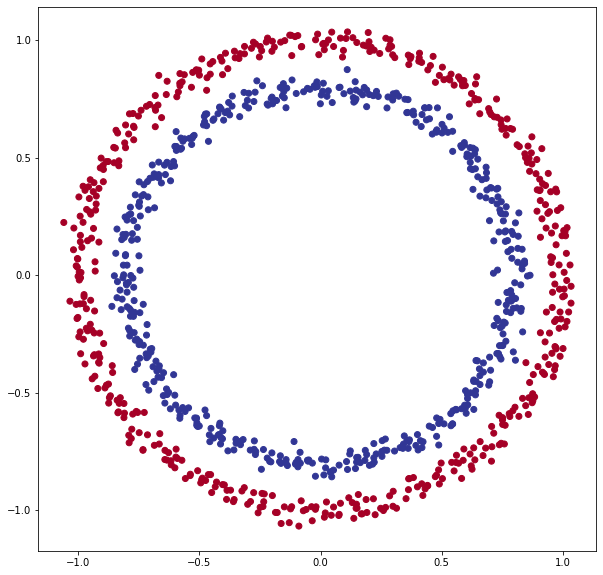

In [6]:
# visualise with a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) # must come before .scatter()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)


 

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

In [7]:
# Check out the dataframe, NB need to use iloc with pandas dataframes

print(circles.iloc[0,:])

circles.iloc[0:6, :] # essentially circles.head()

X0       0.754246
X1       0.231481
Label    1.000000
Name: 0, dtype: float64


,X0,X1,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1


In [8]:
# count the binary labels

circles['Label'].value_counts()
# 500 ones and 500 zeroes

1    500
0    500
Name: Label, dtype: int64

In [9]:
X[0], y[0]
# (array([0.75424625, 0.23148074]), 1)
# Alright, so we've got two X features which lead to one y value
# This means our neural network input shape will has to accept a tensor 
# with at least one dimension being two and output a tensor with at least one value

(array([0.75424625, 0.23148074]), 1)

## Build the model

In [10]:
'''
# Below is my attempt to create the model
# It's different from what is taught/presented in the video here https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24901004#content.
# I split the features and labels into train and test sets


# PREP TRAIN AND TEST DATASETS

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# ((800, 2), (200, 2), (800,), (200,))


# SET SEED

tf.random.set_seed(42)


# CREATE MODEL

model_1 = keras.Sequential(
    [
     keras.layers.Dense(10, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid') # 1 because it's a binary classif
    ]
)

# COMPILE MODEL

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics='accuracy')


# FIT MODEL

model_1.fit(X_train, y_train, epochs=5, verbose=2)


# EVAL MODEL

model_1.evaluate(X_test, y_test) # 
'''

"\n# Below is my attempt to create the model\n# It's different from what is taught/presented in the video here https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24901004#content.\n# I split the features and labels into train and test sets\n\n\n# PREP TRAIN AND TEST DATASETS\n\nfrom sklearn.model_selection import train_test_split  \n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nX_train.shape, X_test.shape, y_train.shape, y_test.shape \n# ((800, 2), (200, 2), (800,), (200,))\n\n\n# SET SEED\n\ntf.random.set_seed(42)\n\n\n# CREATE MODEL\n\nmodel_1 = keras.Sequential(\n    [\n     keras.layers.Dense(10, activation='relu'),\n     keras.layers.Dense(1, activation='sigmoid') # 1 because it's a binary classif\n    ]\n)\n\n# COMPILE MODEL\n\nmodel_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics='accuracy')\n\n\n# FIT MODEL\n\nmodel_1.fit(X

In [11]:
# SET SEED

tf.random.set_seed(42)


# CREATE MODEL

model_1 = keras.Sequential(
    [
     keras.layers.Dense(1)
    ]
)


# COMPILE MODEL

model_1.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.SGD(),
    metrics='accuracy'
)


# FIT MODEL

model_1.fit(X, y, epochs=5, verbose=1)
# our model is only 48% accurate, basically guessing when it comes to binary classification (0 or 1)!


Epoch 1/5
32/32 [==============================] - 1s 1ms/step - loss: 2.8544 - accuracy: 0.4600
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 0.7131 - accuracy: 0.5430
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5090
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5010
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.4830


In [12]:
# IMPROVE THE MODEL 1, train for longer

model_1.fit(X, y, epochs=200, verbose=0)

model_1.evaluate(X, y)
# accuracy is 0.5, so it's even worse!
# NB, we usually only evaluate X_test and y_test

32/32 [==============================] - 0s 906us/step - loss: 0.6935 - accuracy: 0.5000


[0.6934829950332642, 0.5]

In [13]:
# IMPROVE THE MODEL 2, add a layer

tf.random.set_seed(42)

model_2 = keras.Sequential([
                            keras.layers.Dense(1),
                            keras.layers.Dense(1)
])

model_2.compile(loss='BinaryCrossentropy', optimizer='SGD', metrics='accuracy')

model_2.fit(X, y, epochs=100, verbose=0)

model_2.evaluate(X, y) # still poor accuracy ie 50%

32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6933314800262451, 0.5]

In [14]:
# IMPROVE THE MODEL 3A, various improvements: more layers, add activation, new optimizer
# !!! This is the model as per video

tf.random.set_seed(42)

model_3A = keras.Sequential([
                           keras.layers.Dense(100),
                           keras.layers.Dense(10),
                           keras.layers.Dense(1) 
])

model_3A.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics='accuracy')

m3A = model_3A.fit(X, y, epochs=100, verbose=0)

model_3A.evaluate(X, y)
# our loss is extremely low at 0.002; our accuracy is 100% BOOM!

32/32 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.5080


[0.6980254650115967, 0.5080000162124634]

In [15]:
# IMPROVE THE MODEL 3B, various improvements: more layers, add activation, new optimizer

tf.random.set_seed(42)

model_3B = keras.Sequential([
                           keras.layers.Dense(10, activation='relu'),
                           keras.layers.Dense(10, activation='relu'),
                           keras.layers.Dense(10, activation='relu'),
                           keras.layers.Dense(1, activation='sigmoid') 
])

model_3B.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics='accuracy')

m3B = model_3B.fit(X, y, epochs=100, verbose=0)

model_3B.evaluate(X, y)
# our loss is extremely low at 0.002; our accuracy is 100% BOOM!

32/32 [==============================] - 0s 979us/step - loss: 0.0022 - accuracy: 1.0000


[0.0022425150964409113, 1.0]

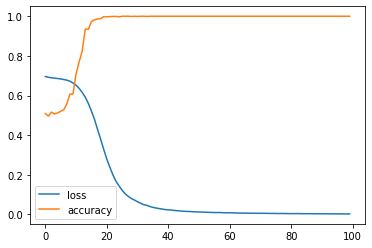

In [16]:
# let's see the model's loss curve

pd.DataFrame(m3B.history).plot()
# accuracy really improves from 20 epochs
# you can add figsize and title args if you want... .plot(figsize=(10,7), title='absence_model_2')


---

To visualize our model's predictions we're going to create a function plot_decision_boundary() which:

* Takes in a trained model, features (X) and labels (y).
* Creates a meshgrid of the different X values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).


In [17]:
# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24909172#content

def plot_decision_boundary(model, X, y):

  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """

  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  #plt.figure(figsize=(10, 10)) # must come before .scatter()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.RdYlBu) # s is size of dot
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


In [18]:
'''
plot_decision_boundary(model=model_3B, X=X, y=y) 
# perfectly draws boundary between red and blue dots!
'''

'\nplot_decision_boundary(model=model_3B, X=X, y=y) \n# perfectly draws boundary between red and blue dots!\n'

doing binary classifcation...


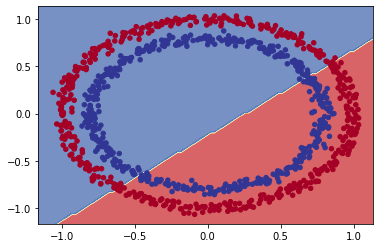

In [19]:
plot_decision_boundary(model=model_3A, X=X, y=y) # Note: using model_3A, as per video

Looks like our model is trying to draw a straight line through the data.
 
What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [20]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

'''
# Fit our model to the data
model_3.fit(X_reg_train, y_reg_train, epochs=100) # WILL THROW AN ERRROR, RUN FROM HERE
'''

'\n# Fit our model to the data\nmodel_3.fit(X_reg_train, y_reg_train, epochs=100) # WILL THROW AN ERRROR, RUN FROM HERE\n'

Oh wait... we compiled our model for a binary classification problem.

No trouble, we can recreate it for a regression problem.



In [21]:
# REVISE THE MODEL 3A TO 3AR FOR REGRESSION ANALYSIS

tf.random.set_seed(42)

model_3AR = keras.Sequential([
                           keras.layers.Dense(100),
                           keras.layers.Dense(10),
                           keras.layers.Dense(1) 
])

model_3AR.compile(loss='mae', optimizer='Adam', metrics='mae')

model_3AR.fit(X_reg_train, y_reg_train, epochs=100, verbose=0)

model_3AR.evaluate(X_reg_train, y_reg_train)
# 

5/5 [==============================] - 0s 2ms/step - loss: 37.8997 - mae: 37.8997


[37.899723052978516, 37.899723052978516]

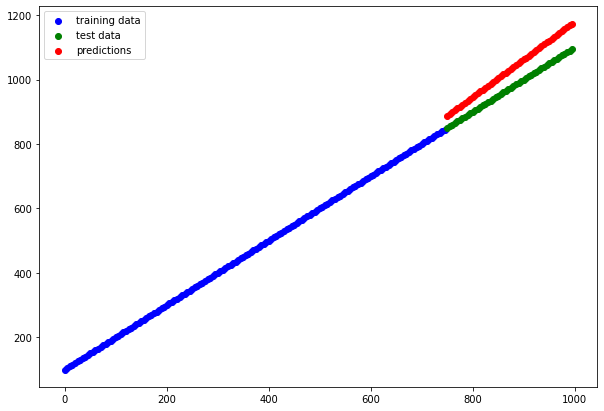

In [22]:
# predict using model above on test dataset

y_reg_pred = model_3AR.predict(X_reg_test)

# plot out the preds against our regression data

plt.figure(figsize=(10,7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='test data')
plt.scatter(X_reg_test, y_reg_pred, c='r', label='predictions')
plt.legend()

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [23]:
# create new binary classif model with linear activation function 
# (as per video https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24927602#content)

# SET SEED
tf.random.set_seed(42)

# CREATE MODEL
model_4 = keras.Sequential([
                            keras.layers.Dense(1, activation='linear'),
])

# COMPILE MODEL
model_4.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# FIT MODEL
m4 = model_4.fit(X, y, epochs=100, verbose=0)

# EVAL MODEL
model_4.evaluate(X, y)
# 0.45 means model is worse than 50% right in predictions!


32/32 [==============================] - 0s 912us/step - loss: 3.2448 - accuracy: 0.4560


[3.2447562217712402, 0.4560000002384186]

doing binary classifcation...


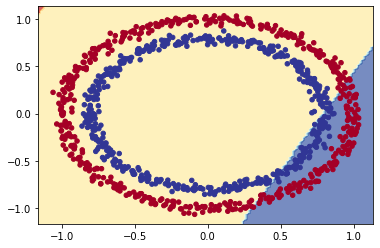

In [24]:
# check decision boundary using the function we created earlier

plot_decision_boundary(model=model_4, X=X, y=y)

In [25]:
# create binary classif model using a non-linear activation function

# SET SEED
tf.random.set_seed(42)

# CREATE MODEL
model_4B = keras.Sequential([
                            keras.layers.Dense(1, activation='relu'),
])

# COMPILE MODEL
model_4B.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# FIT MODEL
m4b = model_4B.fit(X, y, epochs=100, verbose=0)

# EVAL MODEL
model_4B.evaluate(X, y)
# still poor

32/32 [==============================] - 0s 984us/step - loss: 3.2448 - accuracy: 0.4560


[3.2447562217712402, 0.4560000002384186]

In [26]:
# after trying out options on playground.tensorflow.org, we implement a model that seems to work

# SET SEED
tf.random.set_seed(42)

# CREATE MODEL
model_4C = keras.Sequential([
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')
])

# COMPILE MODEL
model_4C.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# FIT MODEL
m4C = model_4C.fit(X, y, epochs=100, verbose=0)

# EVAL MODEL
model_4C.evaluate(X, y)
# our accuracy is now 0.99% which is extremely accurate!

32/32 [==============================] - 0s 1ms/step - loss: 0.2948 - accuracy: 0.9910


[0.2948004901409149, 0.9909999966621399]

doing binary classifcation...


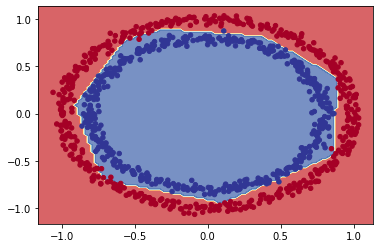

In [27]:
# PLOT

plot_decision_boundary(model=model_4C, X=X, y=y)
# now we see a clear boundary between red and blue dots (X0 and X1)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [28]:
# create toy data to do some experiments on

# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24957122#content

A = tf.cast(tf.range(-10, 10), tf.float32)

A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

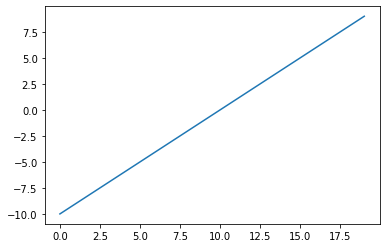

In [29]:
plt.plot(A)

tf.Tensor(
[4.5397872e-05 1.2339458e-04 3.3535014e-04 9.1105117e-04 2.4726233e-03
 6.6928510e-03 1.7986210e-02 4.7425874e-02 1.1920292e-01 2.6894143e-01
 5.0000000e-01 7.3105860e-01 8.8079703e-01 9.5257413e-01 9.8201376e-01
 9.9330717e-01 9.9752742e-01 9.9908900e-01 9.9966466e-01 9.9987662e-01], shape=(20,), dtype=float32)


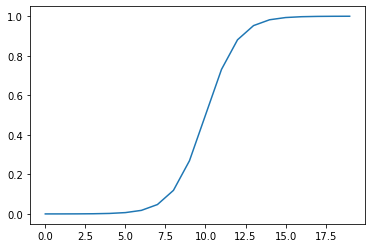

In [30]:
# Sigmoid functions are also useful for many machine learning applications where 
# a real number needs to be converted to a probability. A sigmoid function placed 
# as the last layer of a machine learning model can serve to convert the model's 
# output into a probability score, which can be easier to work with and interpret.

# let's create a func that replicates the sigmoid activation func ie sigmoid(x) = 1 / (1 + exp(-x))

def sigmoid(x):
  return 1 / (1 + tf.exp(-x))

# apply sigmoid activation function on this array

print(sigmoid(A))

# plot it out

plt.plot(sigmoid(A))
# using sigmoid activation func on layers lets the model create curved lines - 
# which is essential for classifying things (curves around data)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], shape=(20,), dtype=float32)


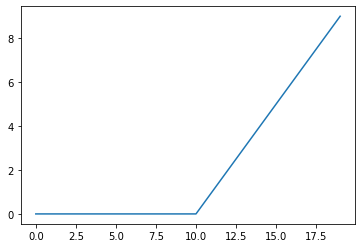

In [31]:
# The Rectified Linear Unit is the most commonly used activation function 
# in deep learning models. The function returns 0 if it receives any negative input, 
# but for any positive value  x  it returns that value back. So it can be written as  f(x)=max(0,x) .

# let's create a func that replicates the relu activation func ie relu = max(x, 0)

def relu(x):
  return tf.maximum(0, x)

# apply relu activation function on this array

print(relu(A))

# plot it out

plt.plot(relu(A))
# using relu activation function in binary classif models let the model 
# draw angular lines around the data 

tf.Tensor(
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.], shape=(20,), dtype=float32)


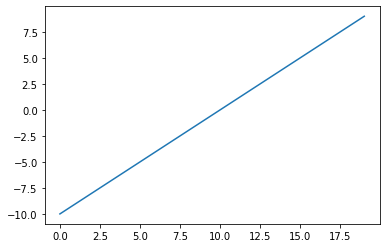

In [32]:
# the linear activation function outputs the values unmodified

print(keras.activations.linear(A))
# exactly the same as A array

plt.plot(keras.activations.linear(A))

**In a nutshell, when we use non-linear activation functions in our models, we let the model *find/deduce patterns in non-linear data*.**

Watch end of https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24957122#content

---


In [33]:
# IMPORT LIBS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Binary Classification Model (now with training and testing data)

We need to use different sets from training and testing.
So let's make new datasets and improve our model with them.

In [34]:
'''from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train[:5], '\n', X_test[:5], '\n', y_train[:5], '\n', y_test[:5]
'''

# Use index to define the datasets, as per video https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24957134#content

# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set


# see shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((800, 2), (200, 2), (800,), (200,))

In [85]:
# let's recreate a model to fit on the training data and evaluate on the testing data

# SET SEED
tf.random.set_seed(42)

# CREATE MODEL
model_5 = keras.Sequential([
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')
])

# COMPILE MODEL
model_5.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics='accuracy')

# FIT MODEL
m5 = model_5.fit(X_train, y_train, epochs=25, verbose=0)

# EVAL MODEL
model_5.evaluate(X_test, y_test)
# accuracy of 100%!



7/7 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 1.0000


[0.1246885135769844, 1.0]

doing binary classifcation...
doing binary classifcation...


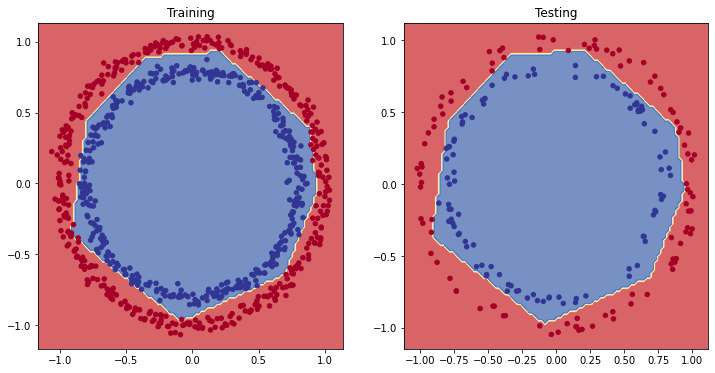

In [36]:
# Plot the decision boundaries for the training and test sets

plt.figure(figsize=(12, 6))

# train
plt.subplot(1, 2, 1)
plot_decision_boundary(model_5, X=X_train, y=y_train)
plt.title('Training');

# test
plt.subplot(1, 2, 2)
plot_decision_boundary(model_5, X=X_test, y=y_test)
plt.title('Testing');


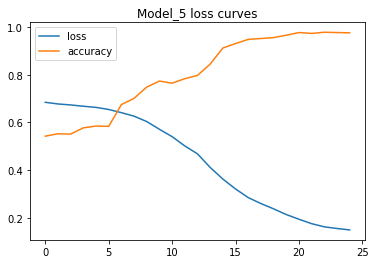

In [37]:
pd.DataFrame(m5.history).plot()
plt.title('Model_5 loss curves');

# pd.DataFrame(m5.history)

## Finding the best learning rate (to begin training our model)

To find the best LR - ***the learning rate where the loss the decreases the most during training*** - let's use the following:
* A **learning rate callback** (think of callback as a functionality you can add while your model is training)
* A new model
* A **modified loss curves plot**




In [38]:
# SEED
tf.random.set_seed(42)

# CREATE 
model_6 = keras.Sequential([
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')
])

# COMPILE
model_6.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics='accuracy')

# CREATE A LEARNING RATE CALLBACK (before fitting the model)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
# '1e-4' means start at 1e-4 and increase the learning rate at every epoch by '10**(epoch/20)'

# FIT (pass the lr_scheduler callback)
m6 = model_6.fit(X_train, y_train, epochs=100, verbose=0, callbacks=lr_scheduler)
# the learning rate is increased by the callback with every epoch

# EVAL
model_6.evaluate(X_test, y_test)




7/7 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4950


[0.6933157444000244, 0.4950000047683716]

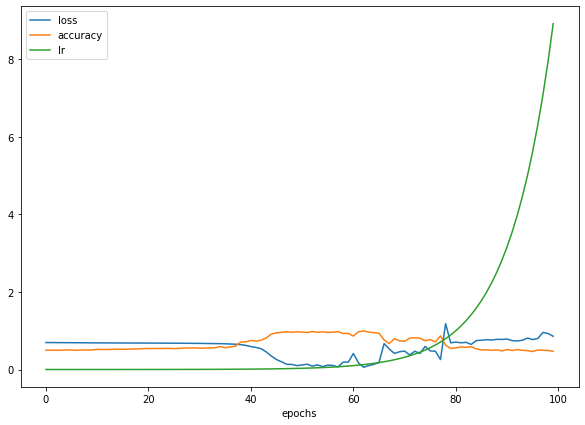

In [39]:
# see history

pd.DataFrame(m6.history).plot(figsize=(10,7), xlabel='epochs')
# the learning rate is increased by the callback with every epoch

## Plot the learning rate decay curve to take a closer look at the learning rate vs loss

tf.Tensor(
[1.00000000e-04 1.12201845e-04 1.25892541e-04 1.41253754e-04
 1.58489319e-04 1.77827941e-04 1.99526231e-04 2.23872114e-04
 2.51188643e-04 2.81838293e-04 3.16227766e-04 3.54813389e-04
 3.98107171e-04 4.46683592e-04 5.01187234e-04 5.62341325e-04
 6.30957344e-04 7.07945784e-04 7.94328235e-04 8.91250938e-04
 1.00000000e-03 1.12201845e-03 1.25892541e-03 1.41253754e-03
 1.58489319e-03 1.77827941e-03 1.99526231e-03 2.23872114e-03
 2.51188643e-03 2.81838293e-03 3.16227766e-03 3.54813389e-03
 3.98107171e-03 4.46683592e-03 5.01187234e-03 5.62341325e-03
 6.30957344e-03 7.07945784e-03 7.94328235e-03 8.91250938e-03
 1.00000000e-02 1.12201845e-02 1.25892541e-02 1.41253754e-02
 1.58489319e-02 1.77827941e-02 1.99526231e-02 2.23872114e-02
 2.51188643e-02 2.81838293e-02 3.16227766e-02 3.54813389e-02
 3.98107171e-02 4.46683592e-02 5.01187234e-02 5.62341325e-02
 6.30957344e-02 7.07945784e-02 7.94328235e-02 8.91250938e-02
 1.00000000e-01 1.12201845e-01 1.25892541e-01 1.41253754e-01
 1.58489319e-

'\nlrs = 1e-4 * (10 ** (np.arange(100)/20))\nplt.figure(figsize=(10, 7))\nplt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale\nplt.xlabel("Learning Rate")\nplt.ylabel("Loss")\nplt.title("Learning rate vs. loss");'

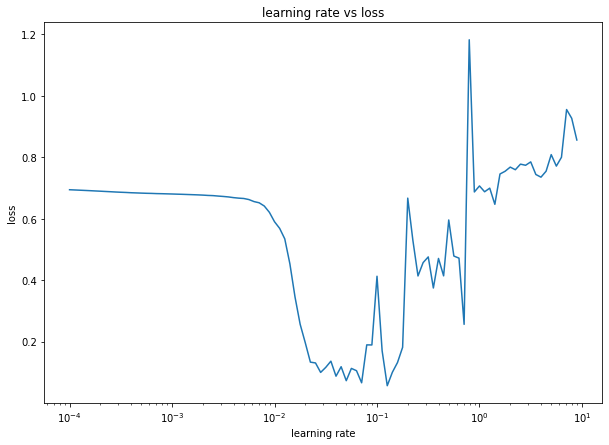

In [40]:
# to take an even closer look, plot the learning rate and loss only - ie the learning rate decay curve

# get the learning rate
lrs = 1e-4 * (10**(tf.range(100)/20))
# we replicate what we passed into LearningRateScheduler() above 
# for epochs we do a list of nums (1 to 100) ie tf.range(100) which is the num of epochs 
print(lrs, '\n')

# how to get loss
print(m6.history, '\n')
print(m6.history['loss'])

# plot out learning rate and loss
plt.figure(figsize=(10,7))
plt.semilogx(lrs, m6.history['loss'])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.title('learning rate vs loss')

'''
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");'''

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`. WHICH IS ONE TICK MARK TO THE RIGHT OF 0.01.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (**a value where the loss is still decreasing**).*

How to read a log scale: https://www.youtube.com/watch?v=8jR-_Om4myk&t=128s

In [41]:
# example of typical learning rates:
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

In [83]:
# tweak model by making lr=0.02

# SEED
tf.random.set_seed(42)

# CREATE 
model_7 = keras.Sequential([
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')
])

# COMPILE
model_7.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.02), metrics='accuracy')

# FIT (pass the lr_scheduler callback)
m7 = model_7.fit(X_train, y_train, epochs=25, verbose=2)
# the learning rate is increased by the callback with every epoch

# EVALUATE
model_7.evaluate(X_test, y_test)
# changing the learning rate can make a massive difference!


Epoch 1/25
25/25 - 0s - loss: 0.6837 - accuracy: 0.5600
Epoch 2/25
25/25 - 0s - loss: 0.6744 - accuracy: 0.5750
Epoch 3/25
25/25 - 0s - loss: 0.6626 - accuracy: 0.5875
Epoch 4/25
25/25 - 0s - loss: 0.6332 - accuracy: 0.6388
Epoch 5/25
25/25 - 0s - loss: 0.5830 - accuracy: 0.7563
Epoch 6/25
25/25 - 0s - loss: 0.4907 - accuracy: 0.8313
Epoch 7/25
25/25 - 0s - loss: 0.4251 - accuracy: 0.8450
Epoch 8/25
25/25 - 0s - loss: 0.3596 - accuracy: 0.8875
Epoch 9/25
25/25 - 0s - loss: 0.3152 - accuracy: 0.9100
Epoch 10/25
25/25 - 0s - loss: 0.2512 - accuracy: 0.9500
Epoch 11/25
25/25 - 0s - loss: 0.2152 - accuracy: 0.9500
Epoch 12/25
25/25 - 0s - loss: 0.1721 - accuracy: 0.9750
Epoch 13/25
25/25 - 0s - loss: 0.1443 - accuracy: 0.9837
Epoch 14/25
25/25 - 0s - loss: 0.1232 - accuracy: 0.9862
Epoch 15/25
25/25 - 0s - loss: 0.1085 - accuracy: 0.9850
Epoch 16/25
25/25 - 0s - loss: 0.0940 - accuracy: 0.9937
Epoch 17/25
25/25 - 0s - loss: 0.0827 - accuracy: 0.9962
Epoch 18/25
25/25 - 0s - loss: 0.0798 - 

[0.046285759657621384, 0.9900000095367432]

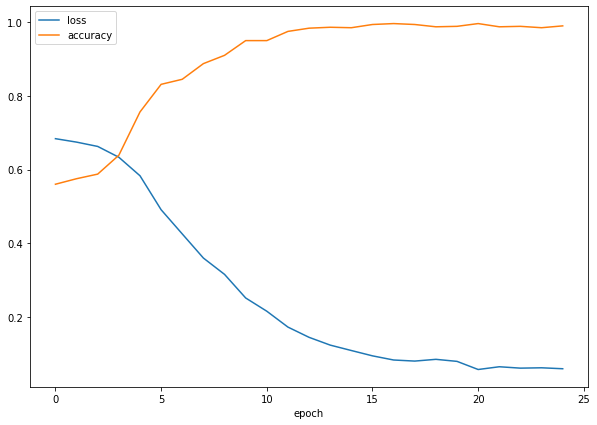

In [43]:
# take a look at the 
pd.DataFrame(m7.history).plot(figsize=(10,7), xlabel='epoch')

# pd.DataFrame(m7.history)

doing binary classifcation...
doing binary classifcation...


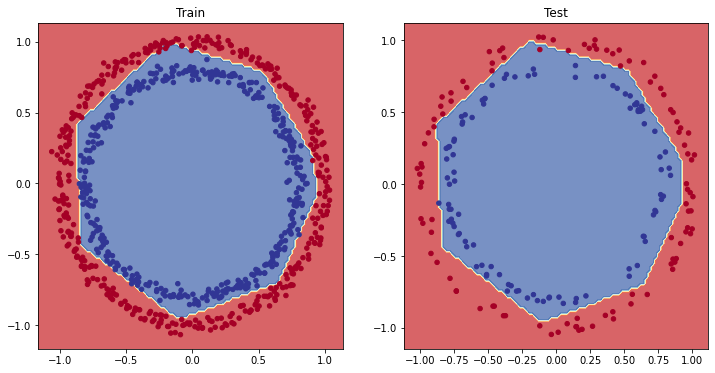

In [44]:
# plot decision boundaries for the training and test sets

plt.figure(figsize=(12,6))

plt.subplot(1,2,1) 
plt.title('Train')
plot_decision_boundary(model_7, X=X_train, y=y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_7, X=X_test, y=y_test)

plt.show()

In a nutshell: find the ideal learning rate then implement it.

---


## More classification evaluation methods - and confusion matrix

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.


(Classification evaluation methods video:
https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24957158#content)



How about a confusion matrix?

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Anatomy of a confusion matrix (what we're going to be creating). Correct predictions appear down the diagonal (from top left to bottom right).*

We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

---


In [45]:
# evaluate using accuracy

loss, accuracy = model_7.evaluate(X_test, y_test)
print(f'Model loss on the test set: {loss}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

'''
# alt
print('Model loss on test set is {loss} \nModel accuracy on test set is {accuracy}%'.format(loss=loss, accuracy=round(accuracy, ndigits=2)))
'''

7/7 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9900
Model loss on the test set: 0.046285759657621384
Model accuracy on the test set: 99.00%


"\n# alt\nprint('Model loss on test set is {loss} \nModel accuracy on test set is {accuracy}%'.format(loss=loss, accuracy=round(accuracy, ndigits=2)))\n"

In [160]:
# evaluate using a confusion matrix

# import sklearn confusion_matrix
from sklearn.metrics import confusion_matrix

# make predictions
y_preds = model_7.predict(X_test)

# because we used a sigmoid activation function in the last layer, output is a probability (from 0 to 1)
print(y_preds[:10], '\n') # see the fist 10 results
print(9.97319937e-01, '\n') # 0.99 percent when you round it, not 9.9 percent

# so we need to round up and down the numbers
y_preds = np.round(y_preds)
print(y_preds[:10], y_test[:10], '\n')

# let's flatten the y_preds tensor (do not have to do this, btw)
# y_preds = tf.reshape(y_preds, [len(y_preds)]) # if using tf to flatten
y_preds = np.ravel(y_preds) # if using np to flatten (see https://numpy.org/doc/1.16/reference/generated/numpy.ravel.html)
print(y_preds[:10], y_test[:10], '\n')

# get len of y_test and y_preds
print(len(y_test), len(y_preds), '\n')
# both are 200 each; 200 is total nums in confusion matrix

# create confusion matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)



[[9.9731982e-01]
 [9.9994922e-01]
 [9.9534464e-01]
 [9.9503756e-01]
 [3.4947401e-01]
 [4.9839616e-03]
 [9.8462188e-01]
 [1.3034195e-02]
 [9.9993813e-01]
 [1.0629889e-04]] 

0.997319937 

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]] [1 1 1 1 0 0 1 0 1 0] 

[1. 1. 1. 1. 0. 0. 1. 0. 1. 0.] [1 1 1 1 0 0 1 0 1 0] 

200 200 

[[100   1]
 [  1  98]]


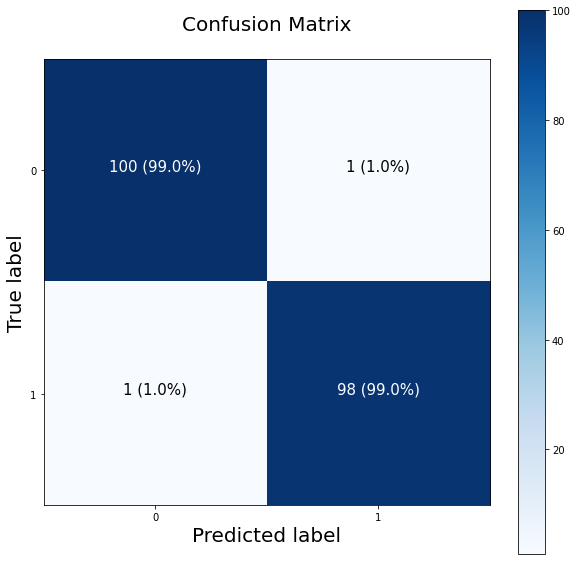

In [88]:
# PRETTIER CONFUSION MATRIX
# make the confusion matrix look better - it's longwinded but if you wanna watch how
# it's here: https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24977994#content
# I copy-pasted the code below (shortcut!)


####

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 

import itertools

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)








In [87]:
# create a function for plotting the confusion matrix

def plot_confusion_matrix(y_test, y_pred):

  import itertools

  # size of matrix
  figsize = (6, 6)

  # Create the confusion matrix
  cm = confusion_matrix(y_test, y_preds)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
  fig.colorbar(cax)

  # Create classes
  classes = False

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.xaxis.label.set_size(20)
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
    horizontalalignment="center",
    color="white" if cm[i, j] > threshold else "black",
    size=15)


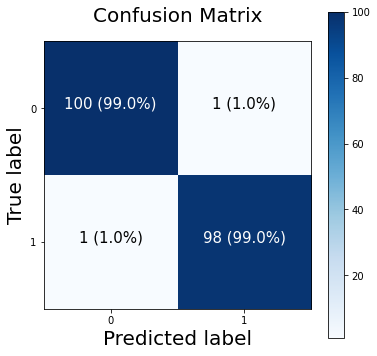

In [89]:

plot_confusion_matrix(y_test, y_preds)

---
---


# MULTICLASS CLASSIFICATION MODEL

Working with a larger example - multiclass classification.

When there is > 2 classes as an option, this is multiclass classif. 

---

Let's build a model to differentiate different types of clothing.

**TF has datasets we can use. We can import it using the tf.keras.datasets module.**

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from keras.datasets import fashion_mnist

(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
# load_data() of this dataset returns: Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
# inspect data

print(train_data[0])
print()

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)
# train_data is a 3D tensor because its shape is (60000, 28, 28)
print()

print(train_labels[0])
# a scalar ie 9
print()

print(train_data[0].shape, train_labels[0].shape)
# note that train_labels[0] is a single number ie a scalar because 9 and shape is ()
# see what the labels stand for here https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [3]:
# see subset of data (NB there are 60000 of 28x28 for train_data and 10000 of 28x28 for test_data)

print(train_data[0:2], '\n', train_data[0].shape)
# train_data is a 3D tensor

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] 
 (28, 28)


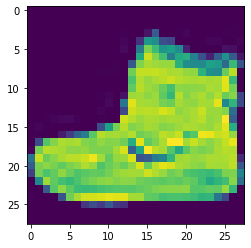

In [4]:
# inspect the images

import matplotlib.pyplot as plt

plt.imshow(train_data[0])
# shows image of boot, ie label=9 in train_labels[0]

Text(0.5, 1.0, 'Sandal')

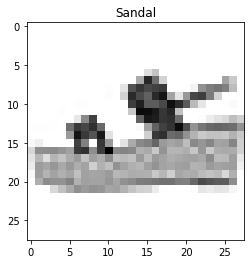

In [5]:
# create a list indexed to labels so we know what label nums represent

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# see train_data item index 12
plt.imshow(train_data[12], cmap=plt.cm.binary) # cmap=plt.cm.binary gives us b&w image

# use class_names in plt.title to tell us what the label of item index 12 is
plt.title(class_names[train_labels[12]])


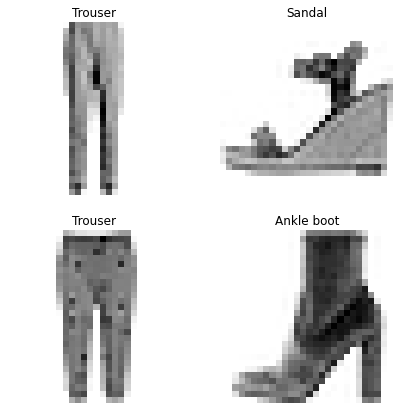

In [6]:
# plot multiple random images so we get a good understanding of the images we're working with
# let's plot a cluster of 4 random images
import random

plt.figure(figsize=(7,7))

for i in range(4):
  plt.subplot(2, 2, i+1) # +1 because range() starts with 0
  rand_img_index = random.randrange(0, len(train_data))
  plt.imshow(train_data[rand_img_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_img_index]])
  plt.axis(False) # removes the X and Y lines



## Build the model


Since this is a multiclass classification problem, we'll need to make a few changes to our architecture:

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function. 
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

// reminder: because our data is non-linear, lines around shapes of clothes, we need activation functions that are non-linear and let the model draw straight lines and curved lines ie relu and Softmax 




In [7]:
# SET SEED
tf.random.set_seed(42)


# CREATE MODEL
model_mc1 = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)), # read FLATTEN DATA below, remove this line to see error
  keras.layers.Dense(4, activation='relu'),
  keras.layers.Dense(4, activation='relu'),
  keras.layers.Dense(10, activation='softmax'),
])

# COMPILE MODEL
model_mc1.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')
# "Use this crossentropy loss function [categorical crossentropy] when there are two or more label classes. 
# We expect labels to be provided in a one_hot representation. 
# If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss."
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy 
# So because our labels are integers and not one-hot encoded, we use SparseCategoricalCrossentropy

# FIT MODEL
mc1 = model_mc1.fit(train_data, train_labels, epochs=10, verbose=2, validation_data=(test_data, test_labels))
# validation_data does evaluation on the fly as you fit the model (I think!)



Epoch 1/10
1875/1875 - 3s - loss: 2.1737 - accuracy: 0.1632 - val_loss: 1.8073 - val_accuracy: 0.1990
Epoch 2/10
1875/1875 - 3s - loss: 1.7242 - accuracy: 0.2413 - val_loss: 1.6588 - val_accuracy: 0.3160
Epoch 3/10
1875/1875 - 2s - loss: 1.6413 - accuracy: 0.2896 - val_loss: 1.6128 - val_accuracy: 0.2874
Epoch 4/10
1875/1875 - 2s - loss: 1.6044 - accuracy: 0.3048 - val_loss: 1.5993 - val_accuracy: 0.3236
Epoch 5/10
1875/1875 - 2s - loss: 1.5906 - accuracy: 0.3161 - val_loss: 1.5782 - val_accuracy: 0.3309
Epoch 6/10
1875/1875 - 3s - loss: 1.5833 - accuracy: 0.3198 - val_loss: 1.5618 - val_accuracy: 0.3282
Epoch 7/10
1875/1875 - 3s - loss: 1.5756 - accuracy: 0.3230 - val_loss: 1.5620 - val_accuracy: 0.3246
Epoch 8/10
1875/1875 - 3s - loss: 1.5720 - accuracy: 0.3204 - val_loss: 1.5795 - val_accuracy: 0.3344
Epoch 9/10
1875/1875 - 3s - loss: 1.5697 - accuracy: 0.3257 - val_loss: 1.5617 - val_accuracy: 0.3392
Epoch 10/10
1875/1875 - 3s - loss: 1.5795 - accuracy: 0.3200 - val_loss: 1.5814 - 

In [8]:
'''
# FLATTEN DATA (from 28x28 to None, 784) or model will have an output error when we fit it
# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/24995622#questions/15320884

flatten_model = keras.Sequential([
                                  keras.layers.Flatten(input_shape=(28,28))
])

flatten_model.output_shape
# (None, 784)
# NNs like inputs to be in one long vector 
'''

'''
model_7.summary(), model_mc1.summary()
# compare model_7 and model_mc1 summaries and note the output shapes
# note the (None, integer) NONE on the left of the shape -- same for both models
# when we Flatten, we get the right output shape for our multiclass classif model

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_69 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_70 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 5         
=================================================================
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_74 (Dense)             (None, 10)                50        
=================================================================
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
______________________________
'''



'\nmodel_7.summary(), model_mc1.summary()\n# compare model_7 and model_mc1 summaries and note the output shapes\n# note the (None, integer) NONE on the left of the shape -- same for both models\n# when we Flatten, we get the right output shape for our multiclass classif model\n\nModel: "sequential_28"\n_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\ndense_69 (Dense)             (None, 4)                 12        \n_________________________________________________________________\ndense_70 (Dense)             (None, 4)                 20        \n_________________________________________________________________\ndense_71 (Dense)             (None, 1)                 5         \n=================================================================\nTotal params: 37\nTrainable params: 37\nNon-trainable params: 0\n____________________________

Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder).

Right now, our training and testing data (not labels) are between 0 and 255 (RGB values). See below...


In [9]:
train_data.min(), train_data.max(), test_data.min(), test_data.max()

(0, 255, 0, 255)

Let's get all our training data - NB not labels! - between 0 and 1 (this is normalising or scaling the data).

We can do this by dividing each number by 255.

OR USE ***tf.keras.utils.normalize()***

In [10]:
train_data_norm = keras.utils.normalize(train_data)

test_data_norm = keras.utils.normalize(test_data)

print(train_data_norm[0], train_data_norm.shape) 
# see that data is now normalised, ie between 0 to 1
# NB shape is (60000, 28, 28)

train_data_norm.min(), train_data_norm.max(), test_data_norm.min(), test_data_norm.max()
# (0.0, 1.0, 0.0, 1.0) 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.01346199 0.    

(0.0, 1.0, 0.0, 1.0)

In [11]:
# Rebuild the model with the new normalised training and testing data


# SET SEED
tf.random.set_seed(42)


# CREATE MODEL
model_mc2 = keras.Sequential([
                              keras.layers.Flatten(input_shape=(28,28)), # see FLATTEN DATA above
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(10, activation='softmax'),
])

# COMPILE MODEL
model_mc2.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# FIT MODEL
mc2 = model_mc2.fit(train_data_norm, train_labels, epochs=10, verbose=2, validation_data=(test_data_norm, test_labels))


Epoch 1/10
1875/1875 - 3s - loss: 1.0415 - accuracy: 0.6192 - val_loss: 0.7083 - val_accuracy: 0.7392
Epoch 2/10
1875/1875 - 2s - loss: 0.6387 - accuracy: 0.7641 - val_loss: 0.6406 - val_accuracy: 0.7735
Epoch 3/10
1875/1875 - 2s - loss: 0.5777 - accuracy: 0.7929 - val_loss: 0.5891 - val_accuracy: 0.7903
Epoch 4/10
1875/1875 - 2s - loss: 0.5409 - accuracy: 0.8095 - val_loss: 0.5570 - val_accuracy: 0.8064
Epoch 5/10
1875/1875 - 2s - loss: 0.5186 - accuracy: 0.8176 - val_loss: 0.5446 - val_accuracy: 0.8091
Epoch 6/10
1875/1875 - 2s - loss: 0.5027 - accuracy: 0.8233 - val_loss: 0.5407 - val_accuracy: 0.8129
Epoch 7/10
1875/1875 - 2s - loss: 0.4922 - accuracy: 0.8266 - val_loss: 0.5407 - val_accuracy: 0.8062
Epoch 8/10
1875/1875 - 2s - loss: 0.4840 - accuracy: 0.8290 - val_loss: 0.5246 - val_accuracy: 0.8171
Epoch 9/10
1875/1875 - 3s - loss: 0.4753 - accuracy: 0.8333 - val_loss: 0.5133 - val_accuracy: 0.8163
Epoch 10/10
1875/1875 - 2s - loss: 0.4707 - accuracy: 0.8335 - val_loss: 0.5074 - 

In [12]:
model_mc1.evaluate(test_data_norm, test_labels)


313/313 [==============================] - 1s 2ms/step - loss: 2.7465 - accuracy: 0.1510


[2.746459484100342, 0.1509999930858612]

Simply by normalising data, we improved the model by loads.

**Normalise your training data (so that X_train and X_test values are between 0 and 1)**

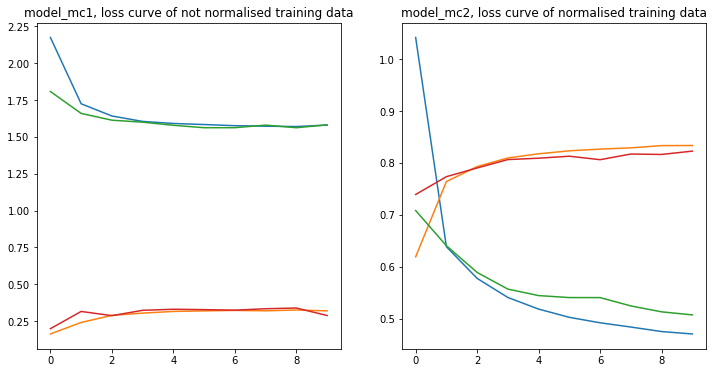

,loss,accuracy,val_loss,val_accuracy
0,1.041527,0.619217,0.708290,0.7392
1,0.638670,0.764133,0.640557,0.7735
2,0.577676,0.792950,0.589104,0.7903
3,0.540897,0.809550,0.557034,0.8064
4,0.518565,0.817550,0.544568,0.8091
5,0.502687,0.823283,0.540746,0.8129
6,0.492192,0.826600,0.540695,0.8062
7,0.483997,0.829000,0.524640,0.8171
8,0.475302,0.833333,0.513258,0.8163
9,0.470653,0.833483,0.507402,0.8227


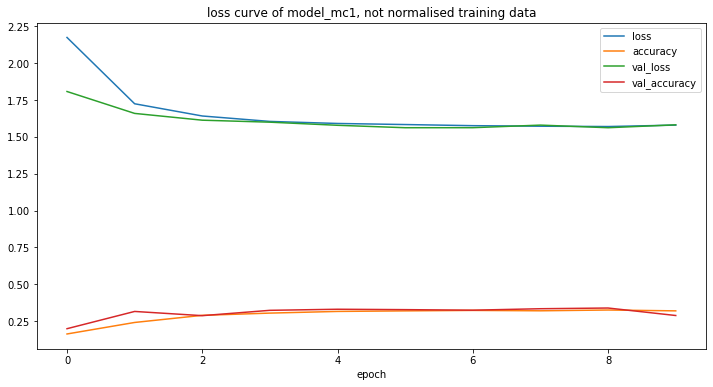

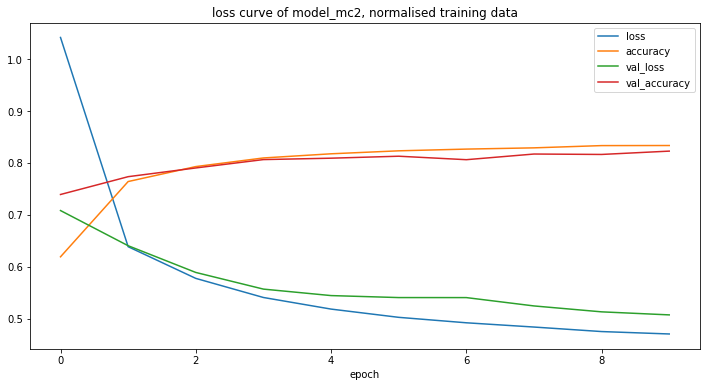

In [13]:
# plot non-normalised and normalised data loss curves side-by-side

plt.figure(figsize=(12,6))

#plot 1:
plt.subplot(1, 2, 1)
plt.title('model_mc1, loss curve of not normalised training data')
plt.xlabel(' ')
plt.plot(pd.DataFrame(mc1.history))

#plot 2:
plt.subplot(1, 2, 2)
plt.title('model_mc2, loss curve of normalised training data')
plt.plot(pd.DataFrame(mc2.history))

plt.show()


# plot it another way

pd.DataFrame(mc1.history).plot(title='loss curve of model_mc1, not normalised training data', xlabel='epoch', figsize=(12,6))
pd.DataFrame(mc2.history).plot(title='loss curve of model_mc2, normalised training data', xlabel='epoch', figsize=(12,6))

pd.DataFrame(mc2.history)

* The same model with tweaked (eg normalised) data can yield dramatic results.
* The same data with tweaked model architecture can yield different results.

Bear this in mind when comparing models.
SO AVOID TOO MANY TWEAKS when comparing models.

## Find the best learning rate

In [14]:
# REBUILD MODEL_MC2 AS MODEL_MC3, WITH NORMALISED TRAINING DATA, AND GET THE BEST LEARNING RATE

# SEED
tf.random.set_seed(42)

# CREATE
model_mc3 = keras.Sequential([
                              keras.layers.Flatten(input_shape=(28,28)),
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(10, activation='softmax')
], name='model_mc3')

# COMPILE
model_mc3.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# CREATE LEARNING RATE CALLBACK
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))
# '1e-3' means start at 1e-3 and increase the learning rate at every epoch by '10**(epoch/20)'
# 1e-3 == 10**-3 == 0.001
# lambda creates an anon function https://www.guru99.com/python-lambda-function.html

# FIT WITH NORMALISED DATA (TRAINING AND TESTING)
mc3 = model_mc3.fit(
    train_data_norm, 
    train_labels, 
    epochs=40, 
    verbose=2, 
    validation_data=(test_data_norm, test_labels), 
    callbacks=[lr_scheduler]
)


Epoch 1/40
1875/1875 - 3s - loss: 1.0415 - accuracy: 0.6192 - val_loss: 0.7083 - val_accuracy: 0.7392
Epoch 2/40
1875/1875 - 2s - loss: 0.6358 - accuracy: 0.7655 - val_loss: 0.6342 - val_accuracy: 0.7777
Epoch 3/40
1875/1875 - 3s - loss: 0.5710 - accuracy: 0.7958 - val_loss: 0.5833 - val_accuracy: 0.7924
Epoch 4/40
1875/1875 - 3s - loss: 0.5315 - accuracy: 0.8141 - val_loss: 0.5505 - val_accuracy: 0.8117
Epoch 5/40
1875/1875 - 3s - loss: 0.5097 - accuracy: 0.8187 - val_loss: 0.5430 - val_accuracy: 0.8079
Epoch 6/40
1875/1875 - 3s - loss: 0.4940 - accuracy: 0.8253 - val_loss: 0.5409 - val_accuracy: 0.8130
Epoch 7/40
1875/1875 - 3s - loss: 0.4845 - accuracy: 0.8288 - val_loss: 0.5229 - val_accuracy: 0.8136
Epoch 8/40
1875/1875 - 3s - loss: 0.4775 - accuracy: 0.8314 - val_loss: 0.5168 - val_accuracy: 0.8179
Epoch 9/40
1875/1875 - 2s - loss: 0.4718 - accuracy: 0.8337 - val_loss: 0.5082 - val_accuracy: 0.8180
Epoch 10/40
1875/1875 - 2s - loss: 0.4698 - accuracy: 0.8324 - val_loss: 0.5132 - 

## Plot the learning rate decay curve (learning rate vs loss)

Text(0.5, 1.0, 'Learning rate vs loss for model_mc3')

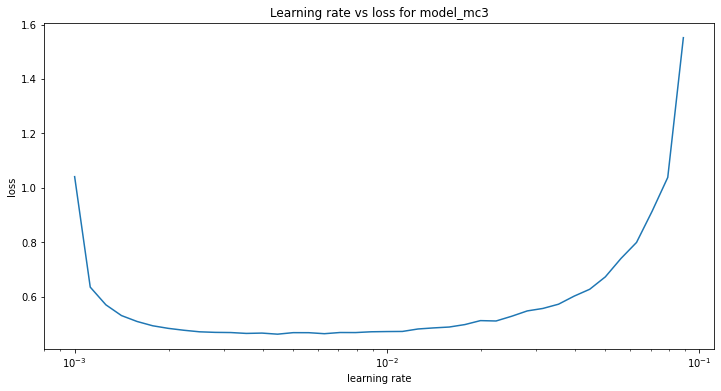

In [15]:
# get learning rate
lrs = 1e-3 * 10**(tf.range(40)/20)
# tf.range(40) because epochs=40

# get loss
loss = mc3.history['loss']
# len(mc3.history['loss']) is 40

# plot it out
plt.figure(figsize=(12,6))
plt.semilogx(lrs, loss)
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.title('Learning rate vs loss for model_mc3')

# note that curve starts from 1e-3 which is 1e-3 == 10**-3 == 0.001

To figure out the ideal value of the learning rate (at least the ideal value to begin training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out.

In [16]:
# loss starts decreasing dramatically but not flattened out between 0.001 and 0.002 
# so if we want to be very precise, the value between both is the square root of 0.001*0.002 (remember this is a log scale, not a linear scale!)

import math

math.sqrt(0.001*0.002)
# 0.001414213562373095 ie 0.001

# CONCLUSION: 
# because the default learning rate for Adam() is 0.001 (ie 10**-3 or 1e-3)
# the default LR is the right one for our model
# (refresher on log scale https://www.youtube.com/watch?v=8jR-_Om4myk&t=128s)


0.001414213562373095

In [17]:
# TWEAK THE MODEL

# SEED
tf.random.set_seed(42)

# CREATE
model_mc4 = keras.Sequential([
                              keras.layers.Flatten(input_shape=(28,28)),
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(4, activation='relu'),
                              keras.layers.Dense(10, activation='softmax')
], name='model_mc4')

# COMPILE
model_mc4.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics='accuracy')

# FIT WITH NORMALISED DATA (TRAINING AND TESTING)
mc4 = model_mc4.fit(
    train_data_norm, 
    train_labels, 
    epochs=40, 
    verbose=2, 
    validation_data=(test_data_norm, test_labels), 
)




Epoch 1/40
1875/1875 - 3s - loss: 1.0415 - accuracy: 0.6192 - val_loss: 0.7083 - val_accuracy: 0.7392
Epoch 2/40
1875/1875 - 2s - loss: 0.6387 - accuracy: 0.7641 - val_loss: 0.6406 - val_accuracy: 0.7735
Epoch 3/40
1875/1875 - 2s - loss: 0.5777 - accuracy: 0.7929 - val_loss: 0.5891 - val_accuracy: 0.7903
Epoch 4/40
1875/1875 - 2s - loss: 0.5409 - accuracy: 0.8095 - val_loss: 0.5570 - val_accuracy: 0.8064
Epoch 5/40
1875/1875 - 2s - loss: 0.5186 - accuracy: 0.8176 - val_loss: 0.5446 - val_accuracy: 0.8091
Epoch 6/40
1875/1875 - 2s - loss: 0.5027 - accuracy: 0.8233 - val_loss: 0.5407 - val_accuracy: 0.8129
Epoch 7/40
1875/1875 - 3s - loss: 0.4922 - accuracy: 0.8266 - val_loss: 0.5407 - val_accuracy: 0.8062
Epoch 8/40
1875/1875 - 2s - loss: 0.4840 - accuracy: 0.8290 - val_loss: 0.5246 - val_accuracy: 0.8171
Epoch 9/40
1875/1875 - 2s - loss: 0.4753 - accuracy: 0.8333 - val_loss: 0.5133 - val_accuracy: 0.8163
Epoch 10/40
1875/1875 - 2s - loss: 0.4707 - accuracy: 0.8335 - val_loss: 0.5074 - 

In [18]:
# NOTE THAT MODEL_MC4 == MODEL_MC3 WITHOUT A LEARNING RATE CALLBACK IN THE FIT
# 40 epochs, val_accuracy: 0.8309

model_mc4.summary()

Model: "model_mc4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                50        
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'epochs')

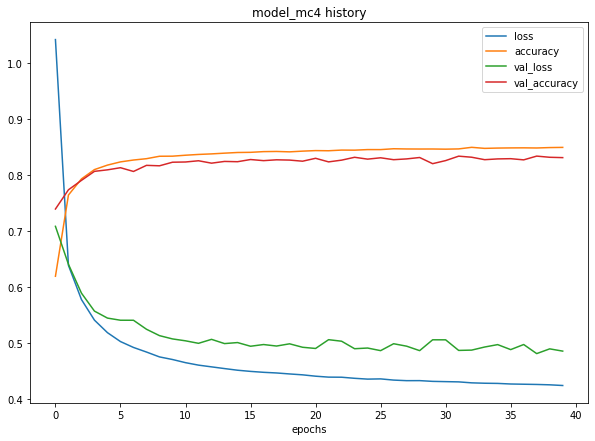

In [19]:

pd.DataFrame(mc4.history).plot(figsize=(10,7))
plt.title('model_mc4 history')
plt.xlabel('epochs')

## Evaluate our model 

In this instance, with a confusion matrix.

In [20]:
# let's functionise our confusion matrix script

def make_confusion_matrix(y_test, y_pred, classes=None, figsize=(6, 6), text_size=15):

  import itertools

  # Create the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)

  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.xaxis.label.set_size(text_size)
  ax.yaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
    horizontalalignment="center",
    color="white" if cm[i, j] > threshold else "black",
    size=text_size)


In [21]:
# PREDICT TEST_DATA_NORM* WITH MODEL TO GET Y_PRED WITH MODEL_MC4 (OUR LATEST MODEL)
# *normalised because the original dataset has nums between 0 to 255

y_pred = model_mc4.predict(test_data_norm)

print(y_pred[0:2], y_pred.shape, '\n')
# !!! results are probabilities (between 0 to 1) x 10 each (per row) and not 1 integer each coz our model's last/output layer uses a softmax activation 
# AND has 10 outputs/neurons !!!
# watch https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25033104#content

'''
# script here is unecessary... 

# convert results to integers
y_pred = np.round(y_pred)

print(y_pred, '\n')
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]...  
# now in ints
'''

# now we create one list with the index of largest num in each y_pred result/row 
y_pred = y_pred.argmax(axis=-1)

print(y_pred) 
# [9 2 1 ... 8 1 5]

print(len(y_pred))
# 10000 ints


'''
# to see a list of y_pred items...

y_pred_items = []

for i in y_pred:
  y_pred_items.append(class_names[i])

print(y_pred_items)
'''


[[1.7648902e-07 1.7250625e-22 1.0758573e-15 3.8790279e-08 8.6007921e-13
  6.3752040e-02 1.5592899e-08 1.7271319e-01 3.4057570e-04 7.6319402e-01]
 [1.1809734e-02 1.2233475e-05 7.8299141e-01 2.0867964e-04 9.0692267e-03
  1.2823346e-24 1.9590278e-01 1.7480957e-32 5.9130089e-06 2.5645757e-14]] (10000, 10) 

[9 2 1 ... 8 1 5]
10000


'\n# to see a list of y_pred items...\n\ny_pred_items = []\n\nfor i in y_pred:\n  y_pred_items.append(class_names[i])\n\nprint(y_pred_items)\n'

In [22]:
# now that y_pred and test_labels are in the same format, we can compare them

print(test_labels[0:10], y_pred[0:10])

print(len(test_labels), len(y_pred))
# 20000 labels in total

[9 2 1 1 6 1 4 6 5 7] [9 2 1 1 6 1 4 6 5 7]
10000 10000


In [23]:
# PLOT A 'BORING' CONFUSION MATRIX

from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix(y_true=test_labels, y_pred=y_pred)

print(cmatrix, '\n', cmatrix.shape, '\n')

flat_cmatrix = np.ravel(cmatrix) # turn it into a vector (1D tensor)
print(sum(flat_cmatrix)) # then work out the sum of nums
# it's 10k which is sum of nums in our confusion matrix


[[805   2  15  55   3   2 103   0  15   0]
 [  6 954   7  26   5   0   1   0   1   0]
 [ 27   1 705   7 142   0 115   0   3   0]
 [ 51  15  10 833  41   0  43   1   6   0]
 [  0   1 112  38 732   0 110   0   7   0]
 [  0   1   0   0   0 939   0  32   3  25]
 [183   2 105  33 102   1 549   1  23   1]
 [  0   0   0   0   0  34   0 943   1  22]
 [  4   1   1   5   5  14  30   7 929   4]
 [  5   0   0   0   0  25   1  49   0 920]] 
 (10, 10) 

10000


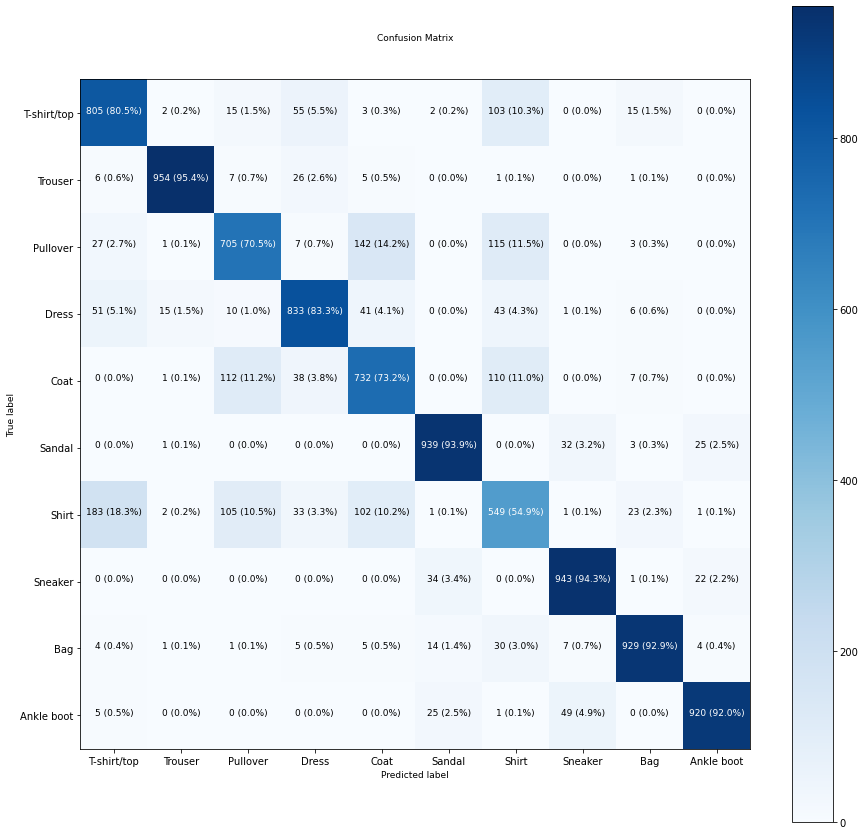

In [24]:
# plot a pretty confusion matrix

make_confusion_matrix(test_labels, y_pred, figsize=(15,15), text_size=9, classes=class_names)

We can see that our model is performing quite well with deep blue boxes making a line from top left to bottom right.

There are a few inaccurate predictions:
- Shirt is being confused with T-shirts/tops (18.3%), pullovers (10.5%) and coats (10.2%) 
- Pullovers are being confused with coats (14.2%) and shirts (11.5%)

Info like this will tell us what data we need more of to train the model better.

In [25]:
# Let's create a function to do the following
# - Plot a random image
# - Make a prediction on image
# - Label the plot with the truth label and predicted label

In [26]:
'''

# I DID THE BELOW ON MY OWN


import random 

# 1. get a random image and its data

# get num of items in test_data dataset
print(len(test_data))
# 10000 items in test_data dataset

# pick a random num from test data
random_img_index = random.randrange(0, len(test_data))

# see random num
print(random_img_index)

# use random num to select an image from test_data dataset
random_img_from_test_data = test_data[random_img_index]

# see the data of the image
print(random_img_from_test_data)

# get the image's class name
print(class_names[test_labels[random_img_index]])

# see the image itself
plt.imshow(random_img_from_test_data)


print()


# 2. normalise the data values of the image  

normalised_data_for_prediction = tf.keras.utils.normalize(random_img_from_test_data)

# see normalised data
print(normalised_data_for_prediction)
# note that the shape is (28, 28), same shape as unnormalised data


print()


# 3. predict with model and get the index num of largest num from the array

img_prediction = model_mc4.predict(normalised_data_for_prediction.reshape(1, 28, 28))
# !!! we use reshape(1,28,28) because we are predicting with 1 image instead of many
# a shape error will occur if array is not reshaped

# see prediction and shape of array. It's an array of probabilities for 10 classes and not one num
print(img_prediction)
print(img_prediction.shape) # (1, 10)

# find largest num in the array 
img_prediction_largest_num_index = np.argmax(img_prediction)

# round the largest num
img_prediction_largest_num_index = np.round(img_prediction_largest_num_index)

# see the num (rounded)
print(img_prediction_largest_num_index)


print()


# 4. use class_names and index of largest num to get the prediction 
# check if prediction matches true label

prediction_final = class_names[img_prediction_largest_num_index]

# see final prediction
print(prediction_final)

# see if there is a match
print(prediction_final == class_names[test_labels[random_img_index]])


'''

"\n\n# I DID THE BELOW ON MY OWN\n\n\nimport random \n\n# 1. get a random image and its data\n\n# get num of items in test_data dataset\nprint(len(test_data))\n# 10000 items in test_data dataset\n\n# pick a random num from test data\nrandom_img_index = random.randrange(0, len(test_data))\n\n# see random num\nprint(random_img_index)\n\n# use random num to select an image from test_data dataset\nrandom_img_from_test_data = test_data[random_img_index]\n\n# see the data of the image\nprint(random_img_from_test_data)\n\n# get the image's class name\nprint(class_names[test_labels[random_img_index]])\n\n# see the image itself\nplt.imshow(random_img_from_test_data)\n\n\nprint()\n\n\n# 2. normalise the data values of the image  \n\nnormalised_data_for_prediction = tf.keras.utils.normalize(random_img_from_test_data)\n\n# see normalised data\nprint(normalised_data_for_prediction)\n# note that the shape is (28, 28), same shape as unnormalised data\n\n\nprint()\n\n\n# 3. predict with model and get 

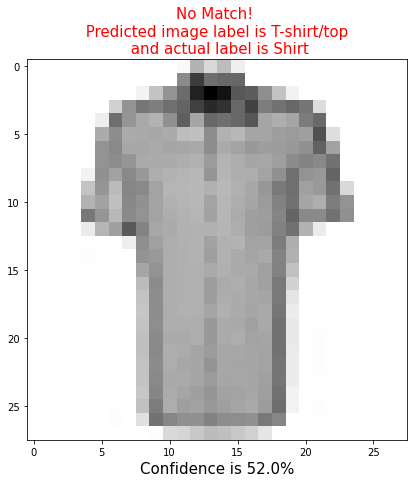

In [31]:

# MY OWN VERSION OF THIS FUNCTION https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25033112#content


def plot_and_predict_img(y_train, y_test, class_names, model_name):

  import random
  import tensorflow as tf
  import numpy as np
  import matplotlib.pyplot as plt

  # get random num
  i = random.randrange(0, len(y_test))

  # get random image's data
  target_img_data = y_train[i] # NB this is unnormalised data

  # get normalised data from target_img data
  target_img_norm = tf.keras.utils.normalize(target_img_data)

  # predict with normalised data, returns an array of probabilities
  y_probabilities = model_name.predict(target_img_norm.reshape(1, 28, 28))

  # get probability (float) of largest num from an array of probabilities
  confidence = np.max(y_probabilities)

  # get index of largest num in array of probabilities
  y_probabilities_index = np.argmax(y_probabilities)

  # get class name of image with y_probabilities_index (img_name is the predicted label)
  img_name = class_names[y_probabilities_index]

  # so now we have the name of the predicted item and we can get the actual item name
  # let's see if name matches the actual label (does y_train == y_test) for this one image

  if img_name == class_names[y_test[i]]:
    #print('MATCH!')
    #print('Predicted image name is {img_name} and actual label is {actual_name}'.format(img_name=img_name, actual_name=class_names[y_test[i]]))
    color='green'
    result='Match!'
  else:
    #print('NO MATCH!')
    #print('Predicted image name is {img_name} and actual label is {actual_name}'.format(img_name=img_name, actual_name=class_names[y_test[i]]))
    color='red'
    result='No Match!'
  # let's plot the target image and the predicted name

  plt.figure(figsize=(7,7))
  plt.imshow(target_img_data, cmap=plt.cm.binary)
  plt.title('{result} \n Predicted image label is {img_name} \n and actual label is {actual_name}'.format(result=result, img_name=img_name, actual_name=class_names[y_test[i]]),
            color=color,
            fontsize=15
            )
  plt.xlabel('Confidence is {confidence}%'.format(confidence=np.around(confidence*100, decimals=2)),
             fontsize=15
             )
  #plt.axis(False)



plot_and_predict_img(test_data, test_labels, class_names, model_mc4)



We create this plot so we can crossreference with our confusion matrix and see what the model is confused with in terms of actual data. 

It's helpful to visualise predictions to grasp a model's performance, whether through visualisations such as the above or a confusion matrix, or both.

## See the patterns our model is learning

(This is very topline and extremely difficult to understand! Watch the video https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25035626#content)

In [35]:
# find the layers of our best model
print(model_mc4.layers)

print()

# extract a particular layer
print(model_mc4.layers[1])

[<keras.layers.core.Flatten object at 0x7f6d692dc290>, <keras.layers.core.Dense object at 0x7f6d692dccd0>, <keras.layers.core.Dense object at 0x7f6d692dcc90>, <keras.layers.core.Dense object at 0x7f6d692fb450>]



And we can find the patterns learned by a particular layer using the `get_weights()` method.

The `get_weights()` method returns the **weights** (also known as a weights matrix) and biases (also known as a bias vector) of a particular layer.

In [37]:
# Get the patterns of a layer in our network
weights, biases = model_mc4.layers[1].get_weights()

# Shape = 1 weight matrix the size of our input data (28x28) per neuron (4)
weights, weights.shape

(array([[ 0.08455554,  1.2486156 ,  0.14914075, -0.38949132],
        [-1.3383611 ,  0.7316643 ,  0.43461242,  0.4288414 ],
        [ 0.04192169, -0.6099002 , -0.2368301 ,  0.03867181],
        ...,
        [-0.14102238, -0.43986258, -1.1347156 , -0.2937157 ],
        [-0.42427206, -0.9310505 , -0.9074982 , -0.60649747],
        [-0.03936215,  0.2979512 , -1.2898993 , -0.2932494 ]],
       dtype=float32), (784, 4))

The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron  in the selected layer (our selected layer has 4 neurons).

Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.

These values start out as random numbers (they're set by the [`kernel_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) when creating a layer, the default is [`"glorot_uniform"`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)) and are then updated to better representative values of the data (non-random) by the neural network during training.

![neural network supervised learning weight updates](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-fashion-mnist-learning.png)
*Example workflow of how a supervised neural network starts with random weights and updates them to better represent the data by looking at examples of ideal outputs.*

Now let's check out the bias vector.

In [38]:
# Shape = 1 bias per neuron (we use 4 neurons in the first layer)
biases, biases.shape

(array([-1.1458514 ,  0.65084594, -0.73250836,  0.8450414 ], dtype=float32),
 (4,))

Every neuron has a bias vector. Each of these is paired with a weight matrix.

The bias values get initialized as zeroes by default (using the [`bias_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [40]:
# Can now calculate the number of parameters in our model
model_mc4.summary()

Model: "model_mc4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                50        
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Now we've built a few deep learning models, it's a good time to point out the whole concept of inputs and outputs not only relates to a model as a whole but to *every* layer within a model.

You might've already guessed this, but starting from the input layer, each subsequent layer's input is the output of the previous layer.

We can see this clearly using the utility [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

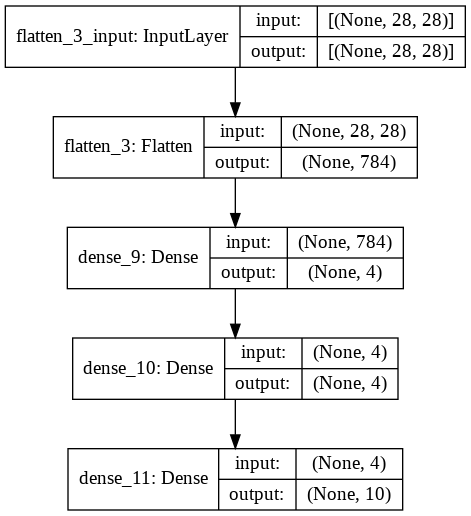

In [42]:
from tensorflow.keras.utils import plot_model

# See the inputs and outputs of each layer
plot_model(model_mc4, show_shapes=True)

## How a model learns (in brief)

Alright, we've trained a bunch of models, but we've never really discussed what's going on under the hood. So how exactly does a model learn?

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the `fit()` fucntion).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

In other words, data and labels pass through a model (**forward pass**) and it attempts to learn the relationship between the data and labels. 

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (**backward pass**) and tweaking its weights matrices and bias values to better represent the data.

If all of this sounds confusing (and it's fine if it does, the above is a very succinct description), check out the resources in the extra-curriculum section for more.

## Exercises 🛠

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?
2. Replicate the model pictured in the [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) below using TensorFlow code. Compile it using the Adam optimizer, binary crossentropy loss and accuracy metric. Once it's compiled check a summary of the model.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)
*Try this network out for yourself on the [TensorFlow Playground website](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Hint: there are 5 hidden layers but the output layer isn't pictured, you'll have to decide what the output layer should be based on the input data.*
3. Create a classification dataset using Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function, visualize it and then build a model to fit it at over 85% accuracy.
4. Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time. Hint: see the [classifcation tutorial in the TensorFlow documentation](https://www.tensorflow.org/tutorials/keras/classification) for ideas.
5. Recreate [TensorFlow's](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) in your own code. Make sure it can accept a tensor and return that tensor after having the softmax function applied to it.
6. Train a model to get 88%+ accuracy on the fashion MNIST test set. Plot a confusion matrix to see the results after.
7. Make a function to show an image of a certain class of the fashion MNIST dataset and make a prediction on it. For example, plot 3 images of the `T-shirt` class with their predictions.



## Extra curriculum 📖
* Watch 3Blue1Brown's neural networks video 2: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). After you're done, write 100 words about what you've learned.
  * If you haven't already, watch video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Note the activation function they talk about at the end.
* Watch [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (if you haven't already) to get an idea of the concepts behind using linear and non-linear functions.
* Spend 1-hour reading [Michael Nielsen's Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/index.html).
* Read the [ML-Glossary documentation on activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Which one is your favourite?
  * After you've read the ML-Glossary, see which activation functions are available in TensorFlow by searching "tensorflow activation functions".

---

---

In [ ]:
# SAVING THE MODEL

'''
# save as 2 formats, h5 and tf

model_mc4.save('model_mc4.h5')

model_mc4.save('model_mc4')

# after that, copy and paste filepath and folder path to save it to a Drive folder

!cp /content/model_mc4.h5 /content/drive/MyDrive/WORK/Code/saved_tf_models

# NOTE:
!cp /content/model_mc4 /content/drive/MyDrive/WORK/Code/saved_tf_models
This will not work; cannot save a tf model to drive, only a .h5 model

# to download the saved model... (works for both .hf and tf files, may take some time)

from google.colab import files

# download the .h5 model saved to specific Drive folder (fast download)
#files.download('/content/drive/MyDrive/WORK/Code/saved_tf_models/model_2.h5')

# download the tf model (very, very slowly)
# files.download('/content/model_mc4')
'''